In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
HOME = os.getcwd()
print(HOME)

/kaggle/working


In [20]:
# Install necessary libraries
!pip install ultralytics==8.0.196
!pip install roboflow --quiet
!pip install inference-sdk --quiet

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import shutil
import random
from IPython.display import display, Image

# Import the inference SDK
from inference_sdk import InferenceHTTPClient


Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5689.6/8062.4 GB disk)


In [21]:
import os
import shutil

# Define local dataset paths
train_images = '/kaggle/input/recogtrial/train/images'
train_labels = '/kaggle/input/recogtrial/train/labels'
val_images = '/kaggle/input/recogtrial/valid/images'
val_labels = '/kaggle/input/recogtrial/valid/labels'
test_images = '/kaggle/input/recogtrial/test/images'
test_labels = '/kaggle/input/recogtrial/test/labels'

# Create the datasets directory in a writable location
writable_datasets_dir = os.path.join('/kaggle/working', 'datasets')
os.makedirs(writable_datasets_dir, exist_ok=True)

# Define writable paths for images and labels
writable_train_images = os.path.join(writable_datasets_dir, 'train/images')
writable_train_labels = os.path.join(writable_datasets_dir, 'train/labels')
writable_val_images = os.path.join(writable_datasets_dir, 'valid/images')
writable_val_labels = os.path.join(writable_datasets_dir, 'valid/labels')
writable_test_images = os.path.join(writable_datasets_dir, 'test/images')
writable_test_labels = os.path.join(writable_datasets_dir, 'test/labels')

# Create writable directories
os.makedirs(writable_train_images, exist_ok=True)
os.makedirs(writable_train_labels, exist_ok=True)
os.makedirs(writable_val_images, exist_ok=True)
os.makedirs(writable_val_labels, exist_ok=True)
os.makedirs(writable_test_images, exist_ok=True)
os.makedirs(writable_test_labels, exist_ok=True)


In [22]:
import os

def get_classes(labels_dir):
    class_set = set()
    for label_file in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, label_file), 'r') as f:
            for line in f:
                class_set.add(line.split()[0])
    return sorted(list(class_set))

# Get classes from train_labels
class_names = get_classes(train_labels)
nc = len(class_names)

data_yaml_content = f"""
train: {writable_train_images}
val: {writable_val_images}
test: {writable_test_images}

# Define the number of classes
nc: {nc}

# Class names
names: {class_names}
"""

# Save data.yaml
data_yaml_path = os.path.join(writable_datasets_dir, 'data.yaml')
with open(data_yaml_path, 'w') as f:
    f.write(data_yaml_content)


In [23]:
# Function to copy images and labels
def copy_images_and_labels(src_labels_dir, src_images_dir, dst_labels_dir, dst_images_dir):
    for label_file in os.listdir(src_labels_dir):
        shutil.copy(os.path.join(src_labels_dir, label_file), dst_labels_dir)
        corresponding_image = label_file.replace('.txt', '.jpg')  # assuming image extension is .jpg
        shutil.copy(os.path.join(src_images_dir, corresponding_image), dst_images_dir)

# Copy train, val, and test datasets
copy_images_and_labels(train_labels, train_images, writable_train_labels, writable_train_images)
copy_images_and_labels(val_labels, val_images, writable_val_labels, writable_val_images)
copy_images_and_labels(test_labels, test_images, writable_test_labels, writable_test_images)


In [24]:
# Initialize the YOLOv8 model
model = YOLO(f'{HOME}/yolov8n.pt')

# Training the model
!yolo task=detect mode=train model=yolov8s.pt data={data_yaml_path} epochs=100 imgsz=800 plots=True


New https://pypi.org/project/ultralytics/8.2.35 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/datasets/data.yaml, epochs=100, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, 

In [41]:
import os

# Define HOME if not already defined
HOME = os.getcwd()

# Update this path with the located weights file
weights_path = os.path.join(HOME, 'runs/detect/train/weights/best.pt')  # Use the correct path for your weights



In [27]:
# Validate the trained model using the found weights file
!yolo task=detect mode=val model={weights_path} data={data_yaml_path}


Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11154609 parameters, 0 gradients, 28.6 GFLOPs
val: Scanning /kaggle/working/datasets/valid/labels.cache... 578 images, 0 backg
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1107.jpg: ignoring corrupt image/label: image size (21, 9) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1141.jpg: ignoring corrupt image/label: image size (18, 8) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1145.jpg: ignoring corrupt image/label: image size (18, 8) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1148.jpg: ignoring corrupt image/label: image size (19, 8) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1152.jpg: ignoring corrupt image/label: image size (19, 7) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1161.jpg: ignoring corrupt image/label: image size (18, 7) <10 pixels
val: WARNING

In [45]:
# Predict on the new dataset images
!yolo task=detect mode=predict model={weights_path} conf=0.25 source={test_images} save=True


Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11154609 parameters, 0 gradients, 28.6 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/619 /kaggle/input/recogtrial/test/images/1005.jpg: 800x512 1 68, 100.8ms
image 2/619 /kaggle/input/recogtrial/test/images/1007.jpg: 800x704 1 63, 85.9ms
image 3/619 /kaggle/input/recogtrial/test/images/1020.jpg: 800x288 1 34, 1 58, 87.3ms
image 4/619 /kaggle/input/recogtrial/test/images/1028.jpg: 800x544 1 40, 84.7ms
image 5/619 /kaggle/input/recogtrial/test/images/1033.jpg: 800x448 1 43, 1 67, 88.4ms
image 6/619 /kaggle/input/recogtrial/test/images/1037.jpg: 800x576 1 39, 84.9ms
image 7/619 /kaggle/input/recogtrial/test/images/1038.jpg: 800x480 1 29, 86.5ms
image 8/619 /kaggle/input/recogtrial/test/images/1042.jpg: 800x512 1 42, 17.1ms
image 9/619 /kaggle/input/recogtrial/test/images/1044.jpg: 800x512 1 30, 16.0ms
image 10/619 /kaggle/input/recogtrial/test/images/1047.jpg: 8

In [48]:
import os

# Define HOME if not already defined
HOME = os.getcwd()

# Update this path with the located weights file
weights_path = os.path.join(HOME, 'runs/detect/train/weights/best.pt')  # Use the correct path for your weights

# Validate the trained model using the found weights file
!yolo task=detect mode=val model={weights_path} data={data_yaml_path}

# Predict on test images
test_images = '/kaggle/input/recognition/test/images'  # Update with your test dataset path
!yolo task=detect mode=predict model={weights_path} conf=0.25 source={test_images} save=True


Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11154609 parameters, 0 gradients, 28.6 GFLOPs
val: Scanning /kaggle/working/datasets/valid/labels.cache... 578 images, 0 backg
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1107.jpg: ignoring corrupt image/label: image size (21, 9) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1141.jpg: ignoring corrupt image/label: image size (18, 8) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1145.jpg: ignoring corrupt image/label: image size (18, 8) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1148.jpg: ignoring corrupt image/label: image size (19, 8) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1152.jpg: ignoring corrupt image/label: image size (19, 7) <10 pixels
val: WARNING ⚠️ /kaggle/working/datasets/valid/images/1161.jpg: ignoring corrupt image/label: image size (18, 7) <10 pixels
val: WARNING


image 1/1 /kaggle/input/recognition/test/images/Crop-1808-_jpg.rf.b357ff31c513da8d1fb61a569ef53b29.jpg: 288x640 (no detections), 86.1ms
Speed: 1.9ms preprocess, 86.1ms inference, 32.2ms postprocess per image at shape (1, 3, 288, 640)


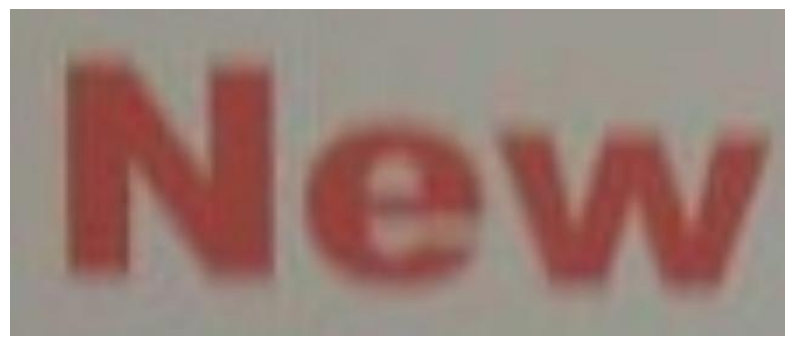

In [58]:
import matplotlib.pyplot as plt
import cv2

def display_image_with_boxes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image at {image_path}")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load YOLO predictions
    results = model.predict(source=image_path, conf=0.25)
    
    # Draw bounding boxes and labels
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = int(box.cls[0])
        conf = box.conf[0]
        
        # Draw rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        # Draw label
        cv2.putText(img, f'{label} {conf:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example usage
# Provide the path to a specific image file within your test dataset
test_image_file = '/kaggle/input/recognition/test/images/Crop-1808-_jpg.rf.b357ff31c513da8d1fb61a569ef53b29.jpg'  # Update with the actual image file path
display_image_with_boxes(test_image_file)



image 1/1 /kaggle/input/recognition/test/images/Crop-2765-_jpg.rf.bb1cc0e72d44d1d76d1b3ad98172055d.jpg: 192x640 (no detections), 8.3ms
Speed: 1.0ms preprocess, 8.3ms inference, 0.8ms postprocess per image at shape (1, 3, 192, 640)


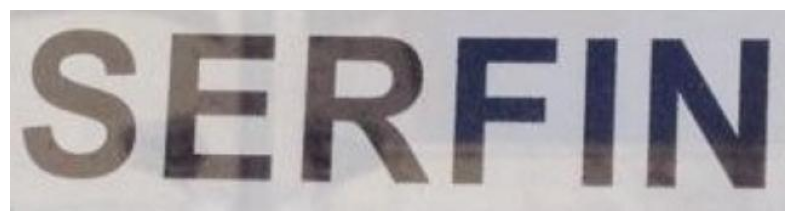

In [61]:
import os
import random

def get_random_image_file(images_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    if not image_files:
        raise ValueError(f"No image files found in directory {images_dir}")
    return os.path.join(images_dir, random.choice(image_files))

# Get a random image file from the test directory
test_images_dir = '/kaggle/input/recognition/test/images'  # Update with your test images directory
random_image_file = get_random_image_file(test_images_dir)

# Display the random image with bounding boxes
display_image_with_boxes(random_image_file)
